# CNN Image Classification using Keras

In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.optimizers import SGD

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('GPU Devices:', tf.config.list_physical_devices('GPU')) # this is for actual GPUs recognized by tensorflow

TensorFlow version: 2.3.1
GPU Devices: []


# Make Classes into One-Hot Vectors

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_test = tf.keras.utils.to_categorical(y_test)
y_train = tf.keras.utils.to_categorical(y_train)

class_names = ['airplane', 'car', 'bird', 'cat' , 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Image Examples

In [3]:
def show_examples(x, y, p = None):
    indices = np.random.choice(range(x.shape[0]), 10, replace = False)
    x = x[indices]
    y = y[indices]
    if not isinstance(p, np.ndarray):
        p = y
    else:
        p = p[indices]
    
    plt.figure(figsize=(4,4))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        
        name = class_names[np.argmax(p[i])]
        
        if col == 'red':
            name = name + "\n(" + class_names[np.argmax(y[i])] + ")"
        plt.xlabel(name, color = col )
        
    plt.show()

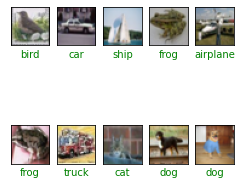

In [4]:
show_examples(x_train, y_train)

# Model Creation And Summary

In [5]:
def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding = 'same'))
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    
    model = add_conv_block(model, 32)    
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam', metrics=['accuracy']
    )
    
    return model

In [6]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

# Model Training

In [9]:
h = model.fit(
    x_train/255., y_train,
    validation_data = (x_test/255., y_test),
    epochs = 200, batch_size = 64,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 20),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only= False,
            monitor='val_accuracy'
        )
    ]
)

Epoch 1/200
782/782 [==============================] - 65s 83ms/step - loss: 1.3885 - accuracy: 0.4907 - val_loss: 1.2095 - val_accuracy: 0.5637
Epoch 2/200
782/782 [==============================] - 67s 85ms/step - loss: 1.2362 - accuracy: 0.5545 - val_loss: 1.1448 - val_accuracy: 0.5879
Epoch 3/200
782/782 [==============================] - 67s 86ms/step - loss: 1.1336 - accuracy: 0.5944 - val_loss: 1.0395 - val_accuracy: 0.6317
Epoch 4/200
782/782 [==============================] - 66s 85ms/step - loss: 1.0650 - accuracy: 0.6191 - val_loss: 0.9051 - val_accuracy: 0.6773
Epoch 5/200
782/782 [==============================] - 65s 83ms/step - loss: 1.0047 - accuracy: 0.6469 - val_loss: 0.9236 - val_accuracy: 0.6765
Epoch 6/200
782/782 [==============================] - 65s 83ms/step - loss: 0.9620 - accuracy: 0.6592 - val_loss: 0.8772 - val_accuracy: 0.6915
Epoch 7/200
782/782 [==============================] - 65s 82ms/step - loss: 0.9289 - accuracy: 0.6727 - val_loss: 0.8218 - val_ac

# Learning Curves

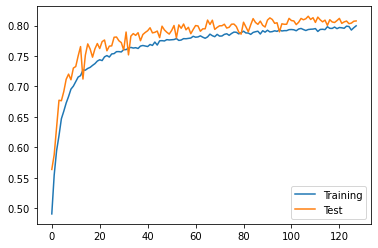

In [10]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label = 'Training')
plt.plot(range(len(accs)), val_accs, label = 'Test')
plt.legend()
plt.show()

In [11]:
mymax = max(h.history['val_accuracy'])
mymodel = 'models/model_{acc:.3f}.h5'.format(acc = mymax)

# Example Predictions from Model

In [14]:
model = tf.keras.models.load_model(mymodel)

In [15]:
preds = model.predict(x_test/255.)

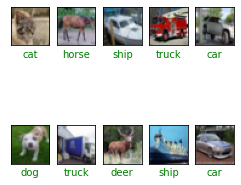

In [16]:
show_examples(x_test, y_test, preds)